# Este notebook trata con el problema de clasificación de vinos en 6 calidades diferentes según la apreciación subjetiva de expertos. Se usan los modelos Support Vector Machine multiclase y Random Forest, obteniendo este último un mejor score (70.3%). Queda pendiente el mejoramiento del modelo y la experimentación con otros modelos.

In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from pprint import pprint  # para imprimir parámetros del modelo
import warnings
warnings.filterwarnings('ignore')

In [129]:

df=pd.read_csv('winequality-white.csv',sep=';')

In [130]:
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Análisis exploratorio

In [131]:
df.shape

(4898, 12)

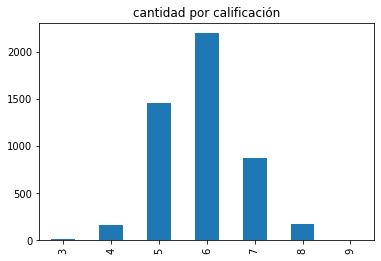

In [132]:
 df['quality'].value_counts().sort_index().plot(kind='bar',title='cantidad por calificación')
                                            

In [133]:
df['quality'].value_counts().sort_index()

3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: quality, dtype: int64

No hay vinos con calificación  1,2 ó 10. Los vinos de calificación normal 6 son los más numerosos.

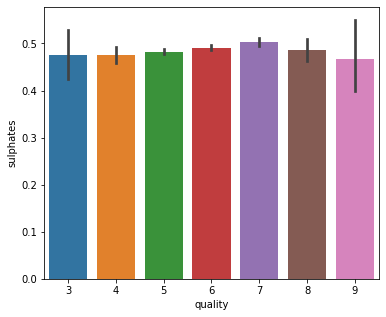

In [134]:
fig = plt.figure(figsize=(6, 5))
sns.barplot(x='quality', y='sulphates', data=df)
plt.show()

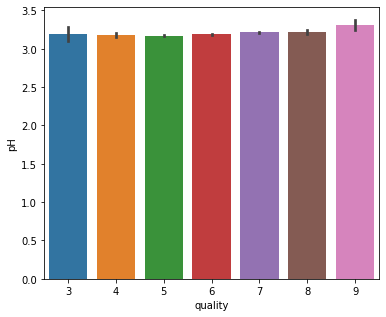

In [135]:
fig = plt.figure(figsize=(6, 5))
sns.barplot(x='quality', y='pH', data=df)
plt.show()

La variable pH tiene una relación directa con la calidad a partir del nivel 4(según medianas). A mayor pH,mayor calidad. El pH "adecuado" está entre 3.0 y 3.5.

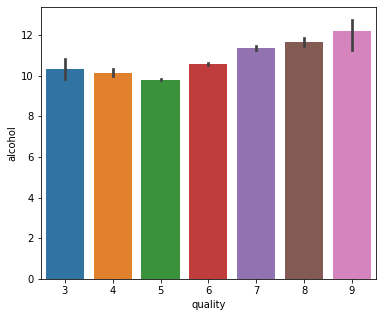

In [136]:
fig = plt.figure(figsize=(6, 5))
sns.barplot(x='quality', y='alcohol', data=df)
plt.show()

A partir del nivel 5, sí hay una relación directa con el nivel de alcohol. Es decir, los vinos con mayor calificación tienen
más alcohol.

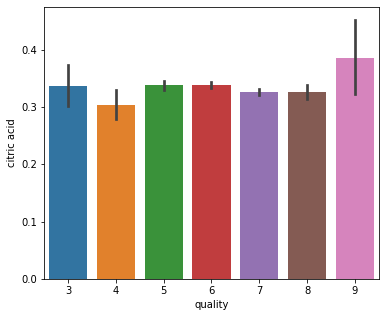

In [137]:
fig = plt.figure(figsize=(6, 5))
sns.barplot(x='quality', y='citric acid', data=df)
plt.show()

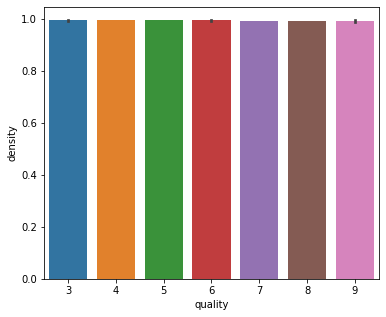

In [138]:
fig = plt.figure(figsize=(6, 5))
sns.barplot(x='quality', y='density', data=df)
plt.show()

Los valores de la densidad están todos cerca de 1. La relación entre las variables la podemos apreciar mejor en
un gráfica de caja:

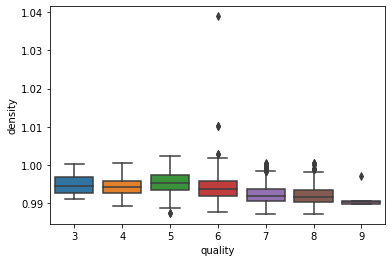

In [139]:
sns.boxplot(x='quality',y='density',data=df)

Así vemos que excepto la calificación 5, mayor calificación del vino está relacionada con una menor 
densidad de éste.

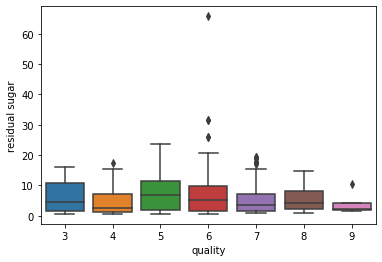

In [140]:
sns.boxplot(x='quality',y='residual sugar',data=df)

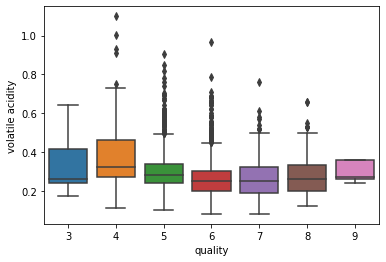

In [141]:
sns.boxplot(x='quality',y='volatile acidity',data=df)

Veamos correlación entre las variables, mediante un heat map:

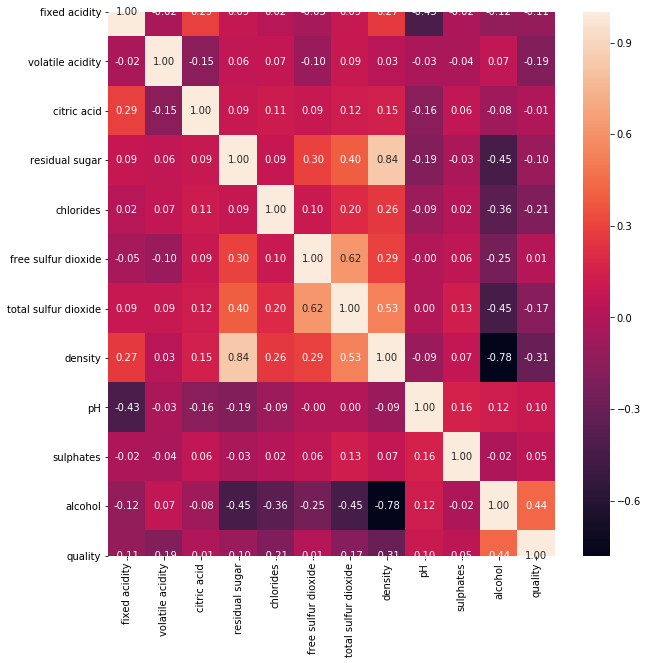

In [142]:
correlations=df.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(correlations, annot=True, fmt=".2f")
plt.show()

Salta a la vista una correlación muy alta y positiva entre la densidad y la azúcar residual:

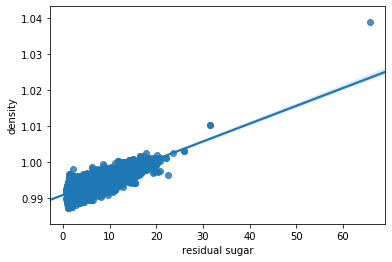

In [143]:
sns.regplot(x='residual sugar',y='density',data=df)

Notemos que la medida con densidad casi 1.04 se encuentra muy alejada de las demás medidas, como también se
puede apreciar en el gráfico de caja entre densidad y calificación anterior. Lo consideraremos como un **outlier
y procederemos a eliminarlo**:

In [144]:
condicion=df['density']>=1.03
df[condicion]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2781,7.8,0.965,0.6,65.8,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,6


In [145]:
df=df.drop(df[df['density']==1.03898].index)

Notemos por último que la variable fre sulfur dioxide está "incluida" en la variable total sulfur dioxide y dada la correlación
que hay entre ambas, optamos por eliminarla:

In [146]:
df=df.drop ('free sulfur dioxide',axis=1)


## Preprocesamiento

### Datos faltantes

In [147]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Vemos que no hay datos faltantes.

### División en train y test

In [148]:
X=df.drop('quality',axis=1) #Separando datos entre variables predictivas y variable objetivo.
Y=df['quality']

In [149]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=8)

In [150]:
X_train.shape,X_test.shape

((3917, 10), (980, 10))

### Normalización

In [151]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)


## Modelación (Machine Learning)

Implementaremos 2 modelos diferentes para comparar:  SVM y Bosque aleatorio (Random Forest)

### SVM multiclase

Modelaremos ahora con el método Support Vector Machine en su versión multiclase.(Tenemos 7 clases diferentes)

In [343]:
model2 = svm.SVC(random_state=3,C=35)

In [344]:
model2.fit(X_train,Y_train)

SVC(C=35, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=3, shrinking=True, tol=0.001,
    verbose=False)

In [345]:
YHAT=model2.predict(X_test)

In [346]:
accuracy_score(Y_test,YHAT)

0.5918367346938775

**Vemos que la precisión del modelo está en 59.1%**

In [347]:
df['quality'].value_counts()/df.shape[0]*100

6    44.864203
5    29.752910
7    17.970186
8     3.573616
4     3.328569
3     0.408413
9     0.102103
Name: quality, dtype: float64

Vemos que más del 90% de los vinos tienen calificación 5, 6 ó 7. Es por esto que en el archivo predictivo Yhat no se ven calificaciones 3,4,8 ó 9.

In [348]:
YHAT

array([6, 6, 5, 7, 6, 6, 5, 5, 7, 5, 6, 7, 7, 6, 5, 6, 5, 6, 8, 6, 5, 6,
       6, 6, 6, 6, 7, 5, 6, 6, 5, 6, 6, 6, 4, 5, 6, 6, 5, 5, 5, 5, 7, 6,
       6, 6, 7, 6, 7, 6, 5, 7, 7, 6, 6, 6, 7, 7, 5, 7, 6, 6, 6, 7, 7, 6,
       7, 6, 6, 7, 7, 6, 7, 6, 5, 6, 6, 6, 7, 5, 6, 7, 5, 5, 6, 6, 6, 5,
       6, 6, 5, 7, 4, 5, 6, 6, 6, 5, 6, 5, 6, 7, 6, 5, 7, 6, 6, 3, 6, 7,
       5, 6, 6, 6, 6, 6, 4, 7, 7, 7, 6, 6, 5, 6, 6, 6, 6, 7, 5, 6, 6, 5,
       7, 6, 4, 5, 6, 7, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 6, 6, 5, 6, 6,
       5, 6, 6, 6, 7, 6, 7, 6, 6, 6, 6, 5, 6, 6, 6, 5, 6, 6, 6, 6, 7, 6,
       5, 5, 6, 5, 6, 7, 6, 5, 5, 6, 6, 6, 6, 6, 5, 6, 7, 7, 6, 6, 6, 6,
       5, 6, 7, 6, 4, 5, 5, 6, 6, 6, 5, 8, 6, 6, 7, 6, 6, 5, 6, 6, 6, 6,
       6, 5, 7, 6, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 7, 7, 6, 8, 6, 6, 6, 6,
       5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 5, 7, 5, 6, 6, 6, 4, 6, 5, 6, 6, 6,
       5, 6, 6, 6, 6, 5, 5, 4, 5, 7, 6, 6, 6, 5, 7, 5, 6, 6, 6, 7, 7, 6,
       5, 8, 7, 5, 6, 7, 6, 7, 7, 6, 6, 6, 6, 5, 6,

### Bosque aleatorio (Random Forest)

In [161]:
# n_estimators=número de árboles
model3 = RandomForestClassifier(n_estimators=75, 
                               bootstrap = True, verbose=2,max_features = 'sqrt',random_state=2,max_depth=24
                               )


#### Entrenamiento

In [163]:
model3.fit(X_train, Y_train)

building tree 1 of 75
building tree 2 of 75
building tree 3 of 75


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 4 of 75
building tree 5 of 75
building tree 6 of 75
building tree 7 of 75
building tree 8 of 75
building tree 9 of 75
building tree 10 of 75
building tree 11 of 75
building tree 12 of 75
building tree 13 of 75
building tree 14 of 75
building tree 15 of 75
building tree 16 of 75
building tree 17 of 75
building tree 18 of 75
building tree 19 of 75
building tree 20 of 75
building tree 21 of 75
building tree 22 of 75
building tree 23 of 75
building tree 24 of 75
building tree 25 of 75
building tree 26 of 75
building tree 27 of 75
building tree 28 of 75
building tree 29 of 75
building tree 30 of 75
building tree 31 of 75
building tree 32 of 75
building tree 33 of 75
building tree 34 of 75
building tree 35 of 75
building tree 36 of 75
building tree 37 of 75
building tree 38 of 75
building tree 39 of 75
building tree 40 of 75
building tree 41 of 75
building tree 42 of 75
building tree 43 of 75
building tree 44 of 75
building tree 45 of 75
building tree 46 of 75
building tree 47 

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=24, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75,
                       n_jobs=None, oob_score=False, random_state=2, verbose=2,
                       warm_start=False)

In [164]:
YT=model3.predict(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.0s finished


In [165]:
print(confusion_matrix(Y_train,YT))
print(classification_report(Y_train,YT))
print(accuracy_score(Y_train, YT))

[[  18    0    0    0    0    0    0]
 [   0  138    0    0    0    0    0]
 [   0    0 1157    0    0    0    0]
 [   0    0    0 1745    0    0    0]
 [   0    0    0    0  716    0    0]
 [   0    0    0    0    0  140    0]
 [   0    0    0    0    0    0    3]]
              precision    recall  f1-score   support

           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00       138
           5       1.00      1.00      1.00      1157
           6       1.00      1.00      1.00      1745
           7       1.00      1.00      1.00       716
           8       1.00      1.00      1.00       140
           9       1.00      1.00      1.00         3

    accuracy                           1.00      3917
   macro avg       1.00      1.00      1.00      3917
weighted avg       1.00      1.00      1.00      3917

1.0


**Claramente tenemos overfitting!.**

### Prediccion con data_train y evaluación modelo

In [166]:
Yrandom=model3.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.0s finished


In [167]:
print(confusion_matrix(Y_test,Yrandom))
print(classification_report(Y_test,Yrandom))
print(accuracy_score(Y_test, Yrandom))

[[  0   0   0   2   0   0   0]
 [  0   7  13   5   0   0   0]
 [  0   2 206  89   3   0   0]
 [  0   0  56 364  31   1   0]
 [  0   0   3  64  97   0   0]
 [  0   0   0  12   8  15   0]
 [  0   0   1   1   0   0   0]]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.78      0.28      0.41        25
           5       0.74      0.69      0.71       300
           6       0.68      0.81      0.74       452
           7       0.70      0.59      0.64       164
           8       0.94      0.43      0.59        35
           9       0.00      0.00      0.00         2

    accuracy                           0.70       980
   macro avg       0.55      0.40      0.44       980
weighted avg       0.71      0.70      0.70       980

0.7030612244897959


**Precisión del 70.3%**

#### Importancia de variables en modelo

In [168]:
labels=['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality']
for feature in zip(labels, model3.feature_importances_):
    print(feature)

('fixed acidity', 0.0839175110355136)
('volatile acidity', 0.11028859522914168)
('citric acid', 0.09115988515560336)
('residual sugar', 0.0957135238290038)
('chlorides', 0.09417160792954526)
('total sulfur dioxide', 0.10286904226864418)
('density', 0.11250069955660073)
('pH', 0.09402979122544738)
('sulphates', 0.09077248255067633)
('alcohol', 0.12457686121982373)


Las variables más importantes son volatile acidity,total sulfur dioxide,density y la más importante es alcohol.
La menos importante es fixed acidity.